In [117]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from codes.ordinal_model import OrdinalRandomForestClassifier

In [99]:
def print_performance(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report

    print('Accuracy:', accuracy_score(y_true, y_pred), '\n',
          'Confusion matrix:\n', confusion_matrix(y_true, y_pred), '\n',
          'Classification report: \n', classification_report(y_true, y_pred))
    
    return None
# =============================================================================
def convert_target(y, object_type, mapper=None):
    '''
    Parameters
    ----------
    y : pd.Series
        The target variable.
    object_type : str in {'category', 'int'}
        The type of target variable. 
    mapper : dict, optional
        The mapping between numerical and categorical variables
    '''
    
    from pandas.api.types import is_integer_dtype
    
    if not (is_integer_dtype(y) or isinstance(y.dtype, pd.CategoricalDtype)):
        raise ValueError('The target variable must be either "int" or "category"')
    
    # Convert numerical into categorical
    if is_integer_dtype(y) and (object_type == 'category'):
        if mapper is None:
            raise ValueError('The argument "mapper" must be provided')
        
        y = y.map(mapper)
        
        category_ordered = []
        for k, v in dict(sorted(mapper.items(), key=lambda x: x[0])).items():
            if not (v in category_ordered):
                category_ordered.append(v)
        print(category_ordered)
        
        y = pd.Series(pd.Categorical(y, categories=category_ordered, ordered=True), index=y.index, name=y.name)
    
    # Convert categorical into numerical
    elif isinstance(y.dtype, pd.CategoricalDtype) and (object_type == 'int'):
        y = pd.Series(y.cat.codes, index=y.index, name=y.name)
    
    else:
        raise ValueError('The object data type is same to the input data type')
    
    return y

# 1. Load dataset

#### (1) Student admission dataset

In [101]:
# Student admission dataset
url = "https://stats.idre.ucla.edu/stat/data/ologit.dta"
data_student = pd.read_stata(url)
data_X = data_student[['pared', 'public', 'gpa']]
data_Y = data_student['apply']
# Data type of target variable ('data_Y'): CategoricalDtype(categories=['unlikely', 'somewhat likely', 'very likely'], ordered=True, categories_dtype=object)

# Convert ordinal target into numeric target
data_Y = convert_target(data_Y, object_type='int')


print('\nShape of data:', data_X.shape, data_Y.shape,
      '\nDistribution of target variables:', data_Y.value_counts().sort_index().to_dict())


Shape of data: (400, 3) (400,) 
Distribution of target variables: {0: 220, 1: 140, 2: 40}


#### (2) Wine quality dataset

In [114]:
# Wine quality dataset
from test_data.load_dataset import load_dataset
data_X, data_Y = load_dataset('wine_quality', preprocess=True, split_target=True)

# Convert numerical variable into ordinal variable
data_Y = convert_target(
    data_Y, object_type='category', 
    mapper={3 : 'Low', 4 : 'Low', 5 : 'Low', 6 : 'Medium', 7 : 'Medium', 8 : 'High', 9 : 'High'})
data_Y = convert_target(data_Y, object_type='int')


print('\nShape of data:', data_X.shape, data_Y.shape,
      '\nDistribution of target variables:', data_Y.value_counts().sort_index().to_dict())

['Low', 'Medium', 'High']

Shape of data: (6497, 12) (6497,) 
Distribution of target variables: {0: 2384, 1: 3915, 2: 198}


#### Split data into train and test sets

In [115]:
# split data into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.3, random_state=42, stratify=data_Y)

print('\nShape of train data:', train_X.shape, train_Y.shape,
      '\nShape of test data:', test_X.shape, test_Y.shape,
      '\nDistribution of train target variables:', train_Y.value_counts().sort_index().to_dict(),
      '\nDistribution of test target variables:', test_Y.value_counts().sort_index().to_dict())


Shape of train data: (4547, 12) (4547,) 
Shape of test data: (1950, 12) (1950,) 
Distribution of train target variables: {1: 2740, 0: 1668, 2: 139} 
Distribution of test target variables: {1: 1175, 0: 716, 2: 59}


# 2. Random Forest

#### (1) Ordinal Random Forest

Accuracy: 0.7553846153846154 
 Confusion matrix:
 [[ 441  275    0]
 [ 151 1024    0]
 [   0   51    8]] 
 Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.62      0.67       716
           1       0.76      0.87      0.81      1175
           2       1.00      0.14      0.24        59

    accuracy                           0.76      1950
   macro avg       0.83      0.54      0.57      1950
weighted avg       0.76      0.76      0.74      1950



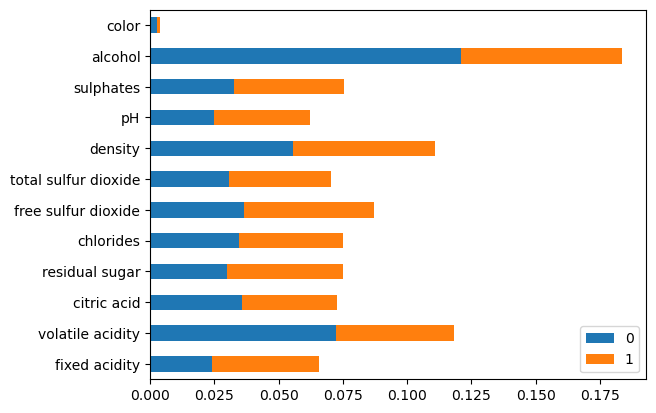

In [116]:
model = OrdinalRandomForestClassifier({'n_estimators': 500, 'max_depth': 8})
model.fit(train_X, train_Y)

# Predict
# predict = model.predict(data_X)
# predict_prob = model.predict_prob(data_X)
# print(np.sum(np.abs(predict_prob.sum(axis=1) - 1)))

# Feature importance
feat_imp = pd.DataFrame(model.feature_importances_, columns=model.classes_[:-1], index=data_X.columns)
feat_imp.plot.barh(stacked=True)

print_performance(test_Y, model.predict(test_X))

In [76]:
# the function convert the ordinal target into binary target
data_Y_info = pd.concat(
    [data_Y.rename('Y label', inplace=False),
     pd.DataFrame(
         model.create_ordinal_target(data_Y),
         index=data_Y.index,
         columns=[f'Y<={i}' for i in range(model.n_classes_-1)])], 
    axis=1)

assert np.all(data_Y_info['Y<=1'] >= data_Y_info['Y<=0'])

#### Random Forest Classification

Accuracy: 0.7492307692307693 
 Confusion matrix:
 [[ 438  278    0]
 [ 152 1023    0]
 [   0   59    0]] 
 Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.61      0.67       716
           1       0.75      0.87      0.81      1175
           2       0.00      0.00      0.00        59

    accuracy                           0.75      1950
   macro avg       0.50      0.49      0.49      1950
weighted avg       0.73      0.75      0.73      1950



C:\ProgramData\miniforge3\envs\py310geo\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\miniforge3\envs\py310geo\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\miniforge3\envs\py310geo\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

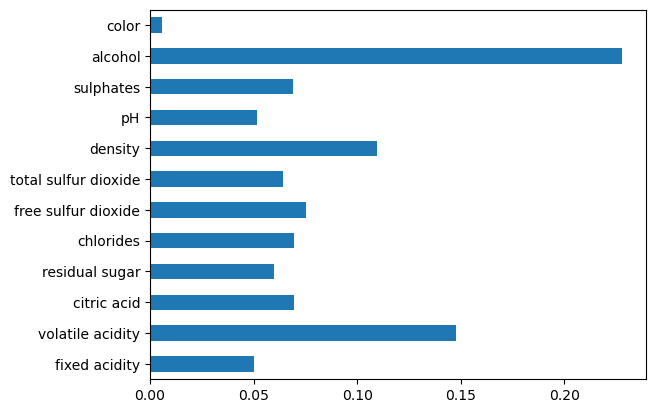

In [78]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_depth=8)
model.fit(train_X, train_Y)

# Feature importance
feat_imp = pd.Series(model.feature_importances_, index=data_X.columns)
feat_imp.plot.barh()

# Model performance
print_performance(test_Y, model.predict(test_X))

In [108]:
def linear_predict(res, data_X, data_Y):
    data_Y_pred = pd.DataFrame(res.predict(data_X).values, columns=data_Y.cat.categories, index=data_X.index) \
                    .idxmax(axis=1)
    return data_Y_pred
# =============================================================================

from statsmodels.miscmodels.ordinal_model import OrderedModel
mod = OrderedModel(train_Y, train_X, distr='logit')

# model fitting
res = mod.fit(method='bfgs', disp=False, maxiter=100)
print(res.summary())

# test performance
test_Y_pred = linear_predict(res, test_X, test_Y)
print_performance(test_Y, test_Y_pred)

                             OrderedModel Results                             
Dep. Variable:                quality   Log-Likelihood:                -2871.0
Model:                   OrderedModel   AIC:                             5770.
Method:            Maximum Likelihood   BIC:                             5860.
Date:                Fri, 10 May 2024                                         
Time:                        15:58:39                                         
No. Observations:                4547                                         
Df Residuals:                    4533                                         
Df Model:                          12                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.0324      0.058      0.559      0.576      -0.081       0.146
volatile acidity      